Copyright © 2025 Amlan Chatterjee. All rights reserved.

RADAR FUNDAMENTALS & SIMULATOR - Part 3
========================================
Micro-Doppler Signatures & Time-Frequency Analysis

Target: Understand and extract micro-Doppler features for drone detection
Timeline: Weekend 2 (Oct 12-13)

Prerequisites: Parts 1 & 2 (RDM (Range-Doppler Map) generation understanding)

In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fft2, fftshift, fftfreq
import warnings
warnings.filterwarnings('ignore')

# Visualization setup
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

---
# Part 3: Micro-Doppler Signatures

## Recap from Part 2

You now understand:
- ✅ Range-Doppler Map (RDM): 2D view of targets (range vs velocity)
- ✅ Doppler shift from moving targets
- ✅ MTI (Moving Target Indicator) filtering to remove stationary clutter

## The Drone Detection Problem

**Challenge:** In an RDM, a drone and a bird at the same range/velocity look identical!
- Both show up as a single bright spot
- Same Doppler frequency (body motion)
- Similar RCS (Radar Cross Section)

**How do we tell them apart?**

**Answer:** **Micro-Doppler signatures** - the unique "fingerprint" from rotating parts!

---
# 1. What is Micro-Doppler?

## Think Back to Basics

Imagine you're watching a ceiling fan from across the room:
- The **fan body** is stationary → no Doppler
- But the **blades** are rotating → they move toward AND away from you!

**At each instant:**
- Blade tip moving toward you → Positive Doppler (+)
- Blade tip moving away → Negative Doppler (−)
- Blade at 90° to you → No radial velocity, zero Doppler

**As the blade rotates:**
- Doppler frequency **oscillates** between + and − at the rotation rate
- This creates a **time-varying Doppler signature** on top of the body's constant Doppler

## Micro-Doppler in Radar

**Main Doppler** = Body motion (drone flying at 15 m/s)
**Micro-Doppler** = Rotating parts (propellers at 3000 RPM (Revolutions Per Minute))

**Key signatures:**
- **Drones:** Periodic blade flashes (4 blades → 4 flashes per rotation)
- **Birds:** Irregular wing beats (2 wings, non-uniform motion)
- **Helicopters:** Strong rotor modulation (large blades)

**This is THE signature that makes drone detection possible!**

## Why RDM Can't Show This

Remember from Part 2:
- RDM shows **one Doppler value per target** (averaged over CPI (Coherent Processing Interval))
- CPI = 128 pulses ≈ 12.8 ms (for PRF (Pulse Repetition Frequency) = 10 kHz (kilohertz))
- Blade rotation period ≈ 20 ms (for 3000 RPM)

**Problem:** The fast blade oscillations are **hidden** in the slow pulse-to-pulse measurements!

**Why averaging hides micro-Doppler:**
```
Pulse 1:  Blade at 0°   → Doppler = body + 0
Pulse 2:  Blade at 18°  → Doppler = body + small_positive
Pulse 3:  Blade at 36°  → Doppler = body + larger_positive
...
Pulse 64: Blade at 180° → Doppler = body + 0
...
Average over CPI: Doppler ≈ body velocity (micro-Doppler cancels out!)
```

**Nyquist consideration:**
- To see 200 Hz (Hertz, cycles per second) blade flash, need sampling rate > 400 Hz (Nyquist)
- PRF = 10 kHz gives 10,000 samples/sec → plenty fast enough
- But RDM averages these samples, losing the time variation!

**Solution:** Look at **time-frequency** evolution using **spectrograms**
- Don't average over full CPI
- Use sliding window (STFT: Short-Time Fourier Transform)
  - STFT divides signal into short overlapping segments and applies FFT to each
  - This reveals how frequency content changes over time
- Show how Doppler changes instant-by-instant
- Reveal the oscillating pattern

**Trade-off:**
- RDM: Good range resolution, averaged Doppler
- Spectrogram: No range info (focus on one cell), time-varying Doppler

---
# 2. Physics of Rotor Blade Modulation

## Geometric Setup

Before diving into equations, let's establish the geometry:

**Drone with horizontal rotor:**
- Rotor plane is horizontal (like a quadcopter)
- Radar is at some angle (could be on ground, or at altitude)
- Rotor disk perpendicular to radar line-of-sight (best case scenario)

**For this tutorial, we assume:**
- Rotor plane faces the radar (aspect angle = 0°)
- This gives maximum micro-Doppler signature
- Real scenarios have varying aspect angles (reduces signature strength)

## Blade Velocity Calculation

Consider a single rotor blade rotating in the horizontal plane:

**Given:**
- Blade length: `r_blade` = 0.15 m (15 cm)
- Angular velocity: `ω` = 3000 RPM = 314 rad/s (radians per second)
- Blade angle at time t: `θ(t) = ωt`

**Blade tip velocity** (tangential, in the rotor plane):
```
v_tangential = r_blade × ω
             = 0.15 m × 314 rad/s
             = 47.1 m/s  (constant magnitude)
```

**Radial component** (toward/away from radar):
As the blade rotates, the component of its velocity along the radar line-of-sight varies:

```
v_radial(t) = r_blade × ω × sin(ωt)

Where:
- sin(ωt) = +1 when blade moves toward radar
- sin(ωt) = -1 when blade moves away from radar  
- sin(ωt) = 0 when blade moves perpendicular to radar
```

**Key insight:** The radial velocity oscillates sinusoidally between:
- Maximum: +r_blade × ω (blade tip approaching radar)
- Minimum: -r_blade × ω (blade tip receding from radar)

## Micro-Doppler Frequency

From the Doppler formula (recall from Part 1): 

```
f_d = 2v/λ

Where:
- f_d = Doppler frequency shift (Hz)
- v = radial velocity (m/s)
- λ = wavelength of radar signal (meters)
```

**What is wavelength (λ)?**
The wavelength is related to the radar carrier frequency:
```
λ = c / f_c

Where:
- c = speed of light = 3 × 10⁸ m/s
- f_c = carrier frequency (Hz)

Example for 10 GHz (Gigahertz) X-band radar:
λ = 3×10⁸ / 10×10⁹ = 0.03 m = 3 cm
```

**Why wavelength matters:**
- Shorter wavelength (higher frequency) → More sensitive to small velocities
- X-band (3 cm) is good compromise: sensitive but not too affected by weather
- Micro-Doppler scales with 1/λ, so higher frequencies see stronger signatures

**Micro-Doppler from radial velocity:**
```
f_micro(t) = (2/λ) × v_radial(t)
           = (2/λ) × r_blade × ω × sin(ωt)
           = f_max × sin(ωt)

Where: f_max = (2 × r_blade × ω) / λ
```

This is the **instantaneous Doppler frequency** caused by the blade motion.

**For multiple blades** (e.g., quadcopter with 4 blades):
- Each blade is offset by 90° (360°/4)
- As rotor rotates, each blade sequentially reaches maximum radial velocity
- This creates **periodic flashes** in the spectrogram
- **Blade flash frequency** = Number of blades × rotation rate (Hz)

## Example Calculation

**Typical quadcopter at hover/cruise:**

**Given:**
```
r_blade = 0.15 m         (15 cm blade radius)
RPM = 3000               (typical hover speed)
ω = 3000 × (2π/60)       (convert to rad/s)
  = 314.16 rad/s
λ = 0.03 m               (10 GHz X-band radar)
num_blades = 4           (quadcopter)
```

**Calculate blade tip velocity:**
```
v_tip = r_blade × ω
      = 0.15 × 314.16
      = 47.1 m/s  (170 km/h!)
```

**Calculate peak micro-Doppler frequency:**
```
f_max = 2 × r_blade × ω / λ
      = 2 × 0.15 × 314.16 / 0.03
      = 3,141.6 Hz
```

**Calculate blade flash rate:**
```
rotation_freq = RPM / 60
              = 3000 / 60
              = 50 Hz

blade_flash_freq = num_blades × rotation_freq
                 = 4 × 50
                 = 200 Hz
```

**Physical interpretation:**
- Micro-Doppler **oscillates** at ±3,141 Hz around the body Doppler
- This oscillation **repeats** 200 times per second (blade flash rate)
- Each blade flash creates a characteristic "stroke" in the spectrogram

**This 200 Hz blade flash rate is what we'll extract from spectrograms!**

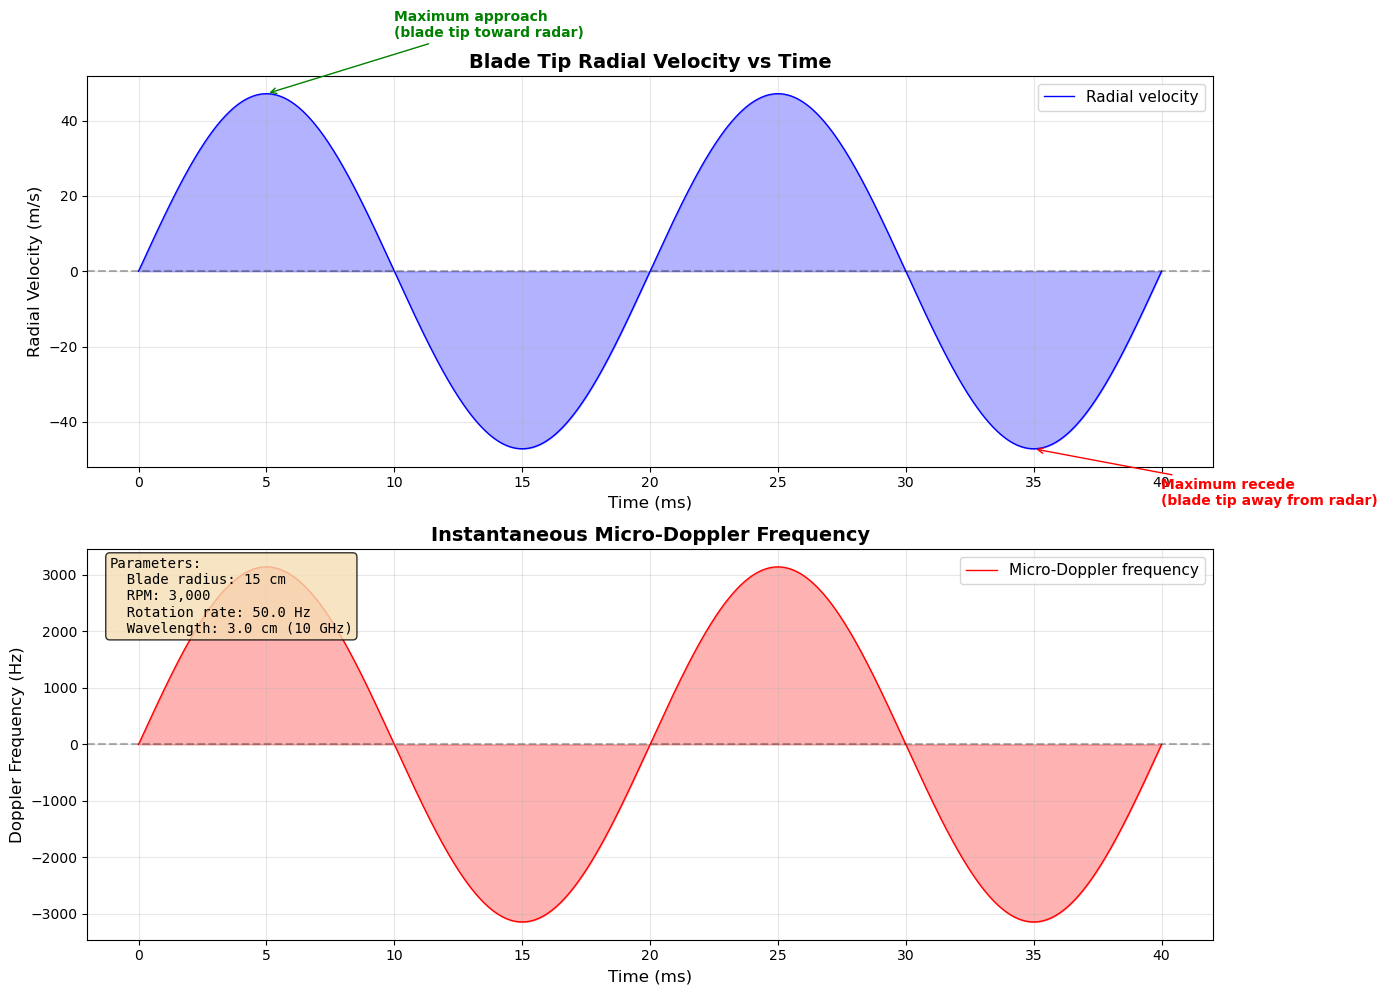


BLADE MODULATION ANALYSIS:
Blade tip velocity: 47.1 m/s (169.6 km/h)
Peak micro-Doppler: ±3141.6 Hz
Modulation frequency: 50.0 Hz (rotation rate)
Period: 20.0 ms per rotation

Key observation:
  → Radial velocity oscillates sinusoidally
  → Micro-Doppler frequency follows the same pattern
  → This creates the characteristic signature in spectrograms


In [ ]:
# Visualization: Single blade micro-Doppler
def visualize_blade_modulation():
    """
    Show how a single rotating blade creates sinusoidal Doppler modulation

    This demonstrates the physics of micro-Doppler before we build the full simulator.
    """
    # Parameters
    r_blade = 0.15  # meters (15 cm)
    rpm = 3000
    omega = rpm * 2 * np.pi / 60  # convert to rad/s
    wavelength = 0.03  # 10 GHz X-band

    # Time array (show 2 full rotations)
    rotation_period = 2 * np.pi / omega
    t = np.linspace(0, 2 * rotation_period, 1000)

    # Blade angle over time
    theta = omega * t

    # Radial velocity of blade tip (toward/away from radar)
    # Positive = approaching, Negative = receding
    v_radial = r_blade * omega * np.sin(theta)

    # Micro-Doppler frequency from radial velocity
    f_micro = 2 * v_radial / wavelength

    # Create figure
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))

    # Plot 1: Blade tip radial velocity
    ax = axes[0]
    ax.plot(t * 1000, v_radial, 'b-', linewidth=1, label='Radial velocity')
    ax.axhline(0, color='k', linestyle='--', alpha=0.3)
    ax.fill_between(t * 1000, 0, v_radial, alpha=0.3, color='blue')
    ax.set_xlabel('Time (ms)', fontsize=12)
    ax.set_ylabel('Radial Velocity (m/s)', fontsize=12)
    ax.set_title('Blade Tip Radial Velocity vs Time', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=11)

    # Add annotations for key points
    max_idx = np.argmax(v_radial)
    min_idx = np.argmin(v_radial)
    zero_idx = len(v_radial) // 4

    ax.annotate('Maximum approach\n(blade tip toward radar)',
                xy=(t[max_idx]*1000, v_radial[max_idx]),
                xytext=(t[max_idx]*1000 + 5, v_radial[max_idx] + 15),
                arrowprops=dict(arrowstyle='->', color='green', lw=1),
                fontsize=10, color='green', fontweight='bold')

    ax.annotate('Maximum recede\n(blade tip away from radar)',
                xy=(t[min_idx]*1000, v_radial[min_idx]),
                xytext=(t[min_idx]*1000 + 5, v_radial[min_idx] - 15),
                arrowprops=dict(arrowstyle='->', color='red', lw=1),
                fontsize=10, color='red', fontweight='bold')

    # Plot 2: Micro-Doppler frequency
    ax = axes[1]
    ax.plot(t * 1000, f_micro, 'r-', linewidth=1, label='Micro-Doppler frequency')
    ax.axhline(0, color='k', linestyle='--', alpha=0.3)
    ax.fill_between(t * 1000, 0, f_micro, alpha=0.3, color='red')
    ax.set_xlabel('Time (ms)', fontsize=12)
    ax.set_ylabel('Doppler Frequency (Hz)', fontsize=12)
    ax.set_title('Instantaneous Micro-Doppler Frequency', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=11)

    # Add parameters as text box
    rotation_rate = rpm / 60
    param_text = (f'Parameters:\n'
                 f'  Blade radius: {r_blade*100:.0f} cm\n'
                 f'  RPM: {rpm:,}\n'
                 f'  Rotation rate: {rotation_rate:.1f} Hz\n'
                 f'  Wavelength: {wavelength*100:.1f} cm (10 GHz)')
    ax.text(0.02, 0.98, param_text, transform=ax.transAxes,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
            verticalalignment='top', fontsize=10, family='monospace')

    plt.tight_layout()
    plt.show()

    # Print key metrics
    print("\n" + "="*60)
    print("BLADE MODULATION ANALYSIS:")
    print("="*60)
    print(f"Blade tip velocity: {r_blade * omega:.1f} m/s ({r_blade * omega * 3.6:.1f} km/h)")
    print(f"Peak micro-Doppler: ±{np.max(np.abs(f_micro)):.1f} Hz")
    print(f"Modulation frequency: {rotation_rate:.1f} Hz (rotation rate)")
    print(f"Period: {rotation_period*1000:.1f} ms per rotation")
    print("="*60)
    print("\nKey observation:")
    print("  → Radial velocity oscillates sinusoidally")
    print("  → Micro-Doppler frequency follows the same pattern")
    print("  → This creates the characteristic signature in spectrograms")
    print("="*60)

# Run visualization
visualize_blade_modulation()

---
# 3. Generating Micro-Doppler Signatures

## The MicroDopplerRadar Class

We'll build a radar simulator that can:
1. Simulate a moving target with rotating blades
2. Generate time-series radar returns
3. Analyze micro-Doppler using spectrograms

**Key difference from Part 2:**
- Part 2: Multiple pulses → 2D FFT (Fast Fourier Transform) → RDM (range-velocity)
- Part 3: Continuous time series → STFT → Spectrogram (time-frequency)

In [ ]:
class MicroDopplerRadar:
    """
    Radar simulator for micro-Doppler analysis

    Simulates continuous radar returns from targets with rotating parts
    Focus: Time-frequency analysis, not range-velocity maps
    """

    def __init__(self, f_c=10e9, prf=10e3, observation_time=1.0,
                 sampling_rate=None):
        """
        Initialize micro-Doppler radar simulator

        Parameters:
        -----------
        f_c : float
            Carrier frequency in Hz (default: 10 GHz X-band)
        prf : float
            Pulse repetition frequency in Hz (default: 10 kHz)
        observation_time : float
            Total observation time in seconds (default: 1.0 s)
        sampling_rate : float
            Sampling rate for time series (default: 2*prf)
        """
        self.f_c = f_c
        self.wavelength = 3e8 / f_c
        self.prf = prf
        self.pri = 1.0 / prf
        self.observation_time = observation_time

        # Sampling rate for continuous simulation
        if sampling_rate is None:
            self.sampling_rate = 2 * prf  # Nyquist
        else:
            self.sampling_rate = sampling_rate

        # Time vector
        self.num_samples = int(observation_time * self.sampling_rate)
        self.time_vector = np.arange(self.num_samples) / self.sampling_rate

        # Signal storage
        self.signal = np.zeros(self.num_samples, dtype=complex)

        # Target list
        self.targets = []

        print("\n" + "="*60)
        print("MicroDopplerRadar Initialized")
        print("="*60)
        print(f"Carrier frequency:    {f_c/1e9:.1f} GHz")
        print(f"Wavelength:           {self.wavelength*100:.2f} cm")
        print(f"PRF:                  {prf/1e3:.1f} kHz")
        print(f"Observation time:     {observation_time:.2f} s")
        print(f"Sampling rate:        {self.sampling_rate/1e3:.1f} kHz")
        print(f"Total samples:        {self.num_samples:,}")
        print("="*60)

    def add_target_with_rotors(self, range_m, velocity_ms, rcs=1.0,
                               num_rotors=4, rotor_radius=0.15, rpm=3000,
                               blade_rcs_fraction=0.1):
        """
        Add a target with rotating blades (e.g., drone)

        Parameters:
        -----------
        range_m : float
            Target range in meters
        velocity_ms : float
            Target radial velocity in m/s (positive = approaching)
        rcs : float
            Radar cross section of main body in m²
        num_rotors : int
            Number of rotor blades
        rotor_radius : float
            Rotor blade radius in meters
        rpm : float
            Rotor rotation speed in RPM
        blade_rcs_fraction : float
            RCS of blade relative to body (typically 0.05 - 0.2)
        """
        target = {
            'range': range_m,
            'velocity': velocity_ms,
            'rcs': rcs,
            'num_rotors': num_rotors,
            'rotor_radius': rotor_radius,
            'rpm': rpm,
            'omega': rpm * 2 * np.pi / 60,  # rad/s
            'blade_rcs': rcs * blade_rcs_fraction,
            'type': 'rotor'
        }
        self.targets.append(target)

        print(f"\n✓ Rotor target added:")
        print(f"  Range: {range_m} m")
        print(f"  Velocity: {velocity_ms:+.1f} m/s ({'approaching' if velocity_ms > 0 else 'receding' if velocity_ms < 0 else 'stationary'})")
        print(f"  RCS: {rcs:.3f} m²")
        print(f"  Rotors: {num_rotors} blades")
        print(f"  Blade radius: {rotor_radius*100:.1f} cm")
        print(f"  RPM: {rpm:,}")
        print(f"  Rotation rate: {rpm/60:.1f} Hz")
        print(f"  Expected blade flash: {num_rotors * rpm/60:.1f} Hz")

    def add_target_with_wings(self, range_m, velocity_ms, rcs=1.0,
                             wing_beat_freq=8, wing_length=0.25,
                             irregularity=0.3):
        """
        Add a target with flapping wings (e.g., bird)

        Parameters:
        -----------
        range_m : float
            Target range in meters
        velocity_ms : float
            Target radial velocity in m/s
        rcs : float
            Radar cross section in m²
        wing_beat_freq : float
            Wing beat frequency in Hz (birds: 5-15 Hz)
        wing_length : float
            Wing length in meters
        irregularity : float
            Wing beat irregularity factor (0=regular, 1=very irregular)
        """
        target = {
            'range': range_m,
            'velocity': velocity_ms,
            'rcs': rcs,
            'wing_beat_freq': wing_beat_freq,
            'wing_length': wing_length,
            'irregularity': irregularity,
            'type': 'wing'
        }
        self.targets.append(target)

        print(f"\n✓ Wing target added (bird):")
        print(f"  Range: {range_m} m")
        print(f"  Velocity: {velocity_ms:+.1f} m/s ({'approaching' if velocity_ms > 0 else 'receding' if velocity_ms < 0 else 'hovering'})")
        print(f"  RCS: {rcs:.3f} m²")
        print(f"  Wing beat freq: {wing_beat_freq:.1f} Hz")
        print(f"  Wing length: {wing_length*100:.1f} cm")
        print(f"  Irregularity: {irregularity:.1%}")

    def generate_signal(self):
        """
        Generate radar return signal with micro-Doppler modulation
        """
        # Reset signal
        self.signal = np.zeros(self.num_samples, dtype=complex)

        for target in self.targets:
            if target['type'] == 'rotor':
                signal_component = self._generate_rotor_signal(target)
            elif target['type'] == 'wing':
                signal_component = self._generate_wing_signal(target)
            else:
                signal_component = self._generate_simple_signal(target)

            self.signal += signal_component

        return self.signal

    def _generate_rotor_signal(self, target):
        """
        Generate signal from target with rotating blades
        """
        # Body Doppler (constant velocity)
        body_doppler = 2 * target['velocity'] / self.wavelength
        body_phase = 2 * np.pi * body_doppler * self.time_vector

        # Body return (main signal)
        body_signal = np.sqrt(target['rcs']) * np.exp(1j * body_phase)

        # Blade micro-Doppler (time-varying)
        omega = target['omega']
        r_blade = target['rotor_radius']
        num_blades = target['num_rotors']

        blade_signal = np.zeros(self.num_samples, dtype=complex)

        # Each blade contributes
        for blade_idx in range(num_blades):
            # Phase offset for this blade
            blade_offset = blade_idx * (2 * np.pi / num_blades)

            # Blade angle over time
            theta = omega * self.time_vector + blade_offset

            # Radial velocity component
            v_blade = r_blade * omega * np.sin(theta)

            # Micro-Doppler frequency
            f_micro = 2 * v_blade / self.wavelength

            # Phase accumulation
            phase_micro = 2 * np.pi * np.cumsum(f_micro) / self.sampling_rate

            # Blade return (modulated)
            blade_signal += np.sqrt(target['blade_rcs']) * np.exp(1j * (body_phase + phase_micro))

        # Total signal
        return body_signal + blade_signal

    def _generate_wing_signal(self, target):
        """
        Generate signal from target with flapping wings (bird)
        """
        # Body Doppler
        body_doppler = 2 * target['velocity'] / self.wavelength
        body_phase = 2 * np.pi * body_doppler * self.time_vector

        # Body return
        body_signal = np.sqrt(target['rcs']) * np.exp(1j * body_phase)

        # Wing modulation (irregular)
        wing_freq = target['wing_beat_freq']
        wing_length = target['wing_length']
        irregularity = target['irregularity']

        # Add irregularity to wing beat
        phase_noise = irregularity * np.cumsum(np.random.randn(self.num_samples)) / self.sampling_rate
        wing_angle = 2 * np.pi * wing_freq * self.time_vector + phase_noise

        # Wing velocity (non-sinusoidal, more realistic)
        v_wing = wing_length * wing_freq * np.sin(wing_angle) * (1 + 0.5 * np.cos(2 * wing_angle))

        # Micro-Doppler from wings
        f_micro = 2 * v_wing / self.wavelength
        phase_micro = 2 * np.pi * np.cumsum(f_micro) / self.sampling_rate

        # Wing contribution (smaller than body)
        wing_signal = 0.3 * np.sqrt(target['rcs']) * np.exp(1j * (body_phase + phase_micro))

        return body_signal + wing_signal

    def _generate_simple_signal(self, target):
        """
        Generate simple signal (no micro-Doppler)
        """
        doppler = 2 * target['velocity'] / self.wavelength
        phase = 2 * np.pi * doppler * self.time_vector
        return np.sqrt(target['rcs']) * np.exp(1j * phase)

    def add_noise(self, snr_db=20):
        """
        Add complex white Gaussian noise to the signal

        Parameters:
        -----------
        snr_db : float
            SNR (Signal-to-Noise Ratio) in dB (decibels, logarithmic power ratio)
        """
        signal_power = np.mean(np.abs(self.signal)**2)
        noise_power = signal_power / (10**(snr_db/10))
        noise = np.sqrt(noise_power/2) * (np.random.randn(self.num_samples) +
                                          1j*np.random.randn(self.num_samples))
        self.signal += noise

        print(f"\n✓ Noise added: SNR = {snr_db} dB")

    def generate_spectrogram(self, nperseg=256, noverlap=None, window='hann'):
        """
        Generate spectrogram using Short-Time Fourier Transform (STFT)

        Parameters:
        -----------
        nperseg : int
            Length of each segment (affects frequency resolution)
        noverlap : int
            Number of overlapping samples (affects time resolution)
        window : str
            Window function ('hann', 'hamming', 'blackman')

        Returns:
        --------
        spectrogram : 2D array
            Time-frequency magnitude spectrogram
        time_axis : array
            Time axis in seconds
        freq_axis : array
            Frequency axis in Hz (Doppler frequencies)
        """
        if noverlap is None:
            noverlap = nperseg // 2

        # Compute STFT
        f, t, Zxx = signal.stft(self.signal,
                                fs=self.sampling_rate,
                                window=window,
                                nperseg=nperseg,
                                noverlap=noverlap,
                                return_onesided=False)

        # Shift zero frequency to center
        f = fftshift(f)
        Zxx = fftshift(Zxx, axes=0)

        # Convert to Doppler velocity
        velocity_axis = f * self.wavelength / 2

        # Magnitude spectrogram
        spectrogram = np.abs(Zxx)

        return spectrogram, t, velocity_axis

    def plot_spectrogram(self, spectrogram, time_axis, velocity_axis,
                        title="Micro-Doppler Spectrogram", db_range=60,
                        annotate=False, body_velocity=None):
        """
        Plot spectrogram with proper scaling and labels

        Parameters:
        -----------
        spectrogram : 2D array
            Spectrogram magnitude data
        time_axis : array
            Time axis in seconds
        velocity_axis : array
            Velocity axis in m/s
        title : str
            Plot title
        db_range : float
            Dynamic range in dB for display
        annotate : bool
            If True, add annotations explaining key features
        body_velocity : float
            Body velocity of target in m/s (for annotations)
        """
        # Convert to dB
        spec_db = 20 * np.log10(spectrogram + 1e-10)
        spec_db -= np.max(spec_db)  # Normalize to 0 dB

        fig, ax = plt.subplots(figsize=(14, 8))

        extent = [time_axis[0]*1000, time_axis[-1]*1000,
                 velocity_axis[0], velocity_axis[-1]]

        im = ax.imshow(spec_db,
                       aspect='auto',
                       extent=extent,
                       cmap='jet',
                       vmin=-db_range, vmax=0,
                       origin='lower',
                       interpolation='bilinear',
                       zorder=1)

        ax.set_xlabel('Time (ms)', fontsize=12)
        ax.set_ylabel('Doppler Velocity (m/s)', fontsize=12)
        ax.set_title(title, fontsize=14, fontweight='bold')
        cbar = plt.colorbar(im, ax=ax, label='Magnitude (dB)')

        cbar.ax.set_zorder(21)  # Put colorbar in background

        ax.axhline(0, color='white', linestyle='--', alpha=0.5, linewidth=1, zorder=3)
        ax.grid(True, alpha=0.3, color='white', linewidth=0.5, zorder=2)

        # Add annotations if requested
        if annotate and body_velocity is not None:
            # Find approximate modulation envelope from spectrogram
            # Average over time to get robust estimate
            velocity_profile = np.mean(spectrogram, axis=1)

            # Find significant energy region (above 20% of max)
            threshold = np.max(velocity_profile) * 0.2
            significant = velocity_profile > threshold
            significant_velocities = velocity_axis[significant]

            if len(significant_velocities) > 0:
                upper_envelope = np.max(significant_velocities)
                lower_envelope = np.min(significant_velocities)
                modulation_bandwidth = upper_envelope - lower_envelope
                print(f"Modulation bandwidth is {modulation_bandwidth}\n")

                # Get DIFFERENT time points for each arrow to avoid crossing
                t_start = time_axis[0] * 1000
                t_end = time_axis[-1] * 1000
                t_upper = t_start + 0.65 * (t_end - t_start)  # 65% along
                t_mid = t_start + 0.5 * (t_end - t_start)    # 50% along
                t_lower = t_start + 0.8 * (t_end - t_start)  # 80% along
                t_right = t_start + 0.95 * (t_end - t_start) # 95% along (rightmost)

                # Draw clean reference lines on the plot - in background
                ax.axhline(body_velocity, color='yellow', linestyle='-', linewidth=1, alpha=0.6, zorder=3)
                ax.axhline(upper_envelope, color='darkblue', linestyle='--', linewidth=1, alpha=0.6, zorder=3)
                ax.axhline(lower_envelope, color='darkblue', linestyle='--', linewidth=1, alpha=0.6, zorder=3)

                # Annotation 1: Upper envelope - arrow from top right to LEFT side of plot
                ax.annotate(f'Upper Envelope {upper_envelope:.0f} m/s',
                           xy=(t_upper, upper_envelope),
                           xytext=(1.12, 0.70),
                           xycoords='data',
                           textcoords='axes fraction',
                           fontsize=10, color='darkblue',
                           bbox=dict(boxstyle='round,pad=0.4', facecolor='white',
                                    edgecolor='darkorange', linewidth=1, alpha=0.85),
                           ha='left', va='center',
                           arrowprops=dict(arrowstyle='-|>', color='slateblue', lw=1),
                           zorder=10)

                # Annotation 2: Body Doppler - arrow pointing to red line at rightmost position
                ax.annotate(f'Body Doppler Velocity {body_velocity:.0f} m/s',
                           xy=(t_right, body_velocity),
                           xytext=(1.12, 0.50),
                           xycoords='data',
                           textcoords='axes fraction',
                           fontsize=10, color='darkblue',
                           bbox=dict(boxstyle='round,pad=0.5', facecolor='white',
                                    edgecolor='darkorange', linewidth=1, alpha=0.85),
                           ha='left', va='center',
                           arrowprops=dict(arrowstyle='-|>', lw=1, color='orange'),
                           zorder=10)

                # Annotation 3: Lower envelope - arrow from bottom right to RIGHT side of plot
                ax.annotate(f'Lower Envelope {lower_envelope:.0f} m/s',
                           xy=(t_lower, lower_envelope),
                           xytext=(1.12, 0.30),
                           xycoords='data',
                           textcoords='axes fraction',
                           fontsize=10, color='darkblue',
                           bbox=dict(boxstyle='round,pad=0.4', facecolor='white',
                                    edgecolor='darkorange', linewidth=1, alpha=0.85),
                           ha='left', va='center',
                           arrowprops=dict(arrowstyle='-|>', lw=1, color='slateblue'),
                           zorder=10)

        plt.tight_layout()
        plt.show()

# Test the class
print("\n" + "="*60)
print("MicroDopplerRadar class defined successfully!")
print("="*60)


MicroDopplerRadar class defined successfully!


---
# 4. Example 1: Single Drone with Rotors

Let's simulate a quadcopter drone and see its micro-Doppler signature!


MicroDopplerRadar Initialized
Carrier frequency:    10.0 GHz
Wavelength:           3.00 cm
PRF:                  10.0 kHz
Observation time:     0.50 s
Sampling rate:        20.0 kHz
Total samples:        10,000

✓ Rotor target added:
  Range: 1500 m
  Velocity: +20.0 m/s (approaching)
  RCS: 0.010 m²
  Rotors: 4 blades
  Blade radius: 15.0 cm
  RPM: 3,000
  Rotation rate: 50.0 Hz
  Expected blade flash: 200.0 Hz

✓ Noise added: SNR = 15 dB
Modulation bandwidth is 2.34375



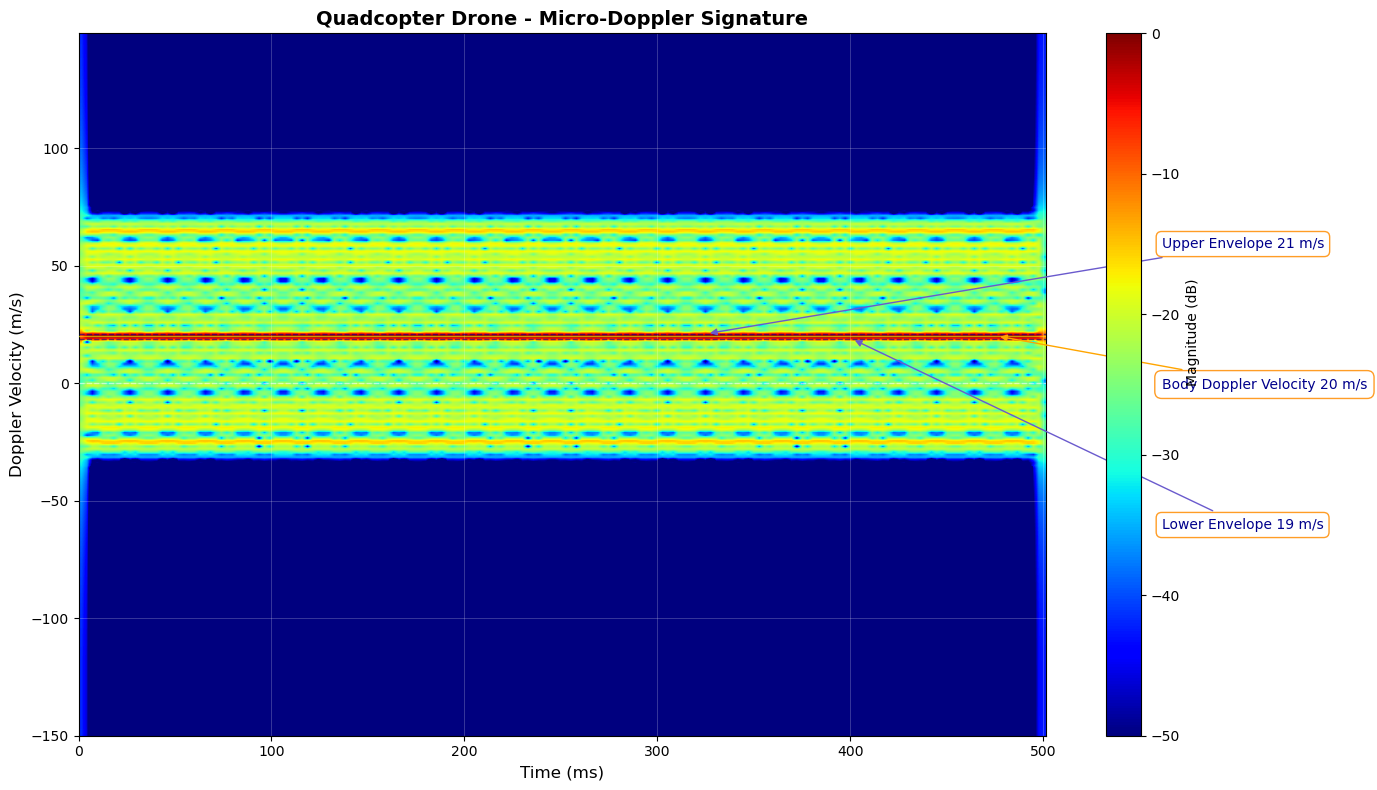


WHAT TO LOOK FOR IN THE SPECTROGRAM:
✓ Bright red/yellow band centered at ~20 m/s: Body Doppler velocity
✓ Sinusoidal modulation pattern: Blade micro-Doppler signature
✓ Upper/lower envelopes: Blade approaching/receding from radar
✓ Modulation bandwidth: Total spread caused by rotating blades
✓ Periodic pattern: 4 blade flashes per rotation

Expected blade flash rate: 4 × 50 Hz = 200 Hz
Note: The body velocity is the CENTER of the modulated band,
      not a thin horizontal line!


In [ ]:
def example_single_drone():
    """
    Simulate a drone with 4 rotors and visualize micro-Doppler
    """
    # Define parameters
    body_velocity = 20  # m/s
    num_blades = 4
    rpm = 3000
    rotor_radius = 0.15  # meters

    # Create radar
    radar = MicroDopplerRadar(
        f_c=10e9,           # 10 GHz X-band
        prf=10e3,           # 10 kHz PRF
        observation_time=0.5  # 500 ms observation
    )

    # Add quadcopter drone
    radar.add_target_with_rotors(
        range_m=1500,        # 1.5 km away
        velocity_ms=body_velocity,
        rcs=0.01,            # Small RCS (10 cm² = 0.01 m²)
        num_rotors=num_blades,
        rotor_radius=rotor_radius,
        rpm=rpm,
        blade_rcs_fraction=0.1  # Blades are 10% of body RCS
    )

    # Add noise
    radar.add_noise(snr_db=15)

    # Generate signal
    radar.generate_signal()

    # Generate spectrogram
    spec, t_axis, v_axis = radar.generate_spectrogram(
        nperseg=256,      # Frequency resolution
        noverlap=200      # Time resolution
    )

    # Plot with annotations
    radar.plot_spectrogram(spec, t_axis, v_axis,
                          title="Quadcopter Drone - Micro-Doppler Signature",
                          db_range=50,
                          annotate=True,
                          body_velocity=body_velocity)

    # Calculate expected values
    rotation_freq = rpm / 60  # Hz
    blade_flash_rate = num_blades * rotation_freq  # Hz

    # Analysis
    print("\n" + "="*60)
    print("WHAT TO LOOK FOR IN THE SPECTROGRAM:")
    print("="*60)
    print(f"✓ Bright red/yellow band centered at ~{body_velocity} m/s: Body Doppler velocity")
    print("✓ Sinusoidal modulation pattern: Blade micro-Doppler signature")
    print("✓ Upper/lower envelopes: Blade approaching/receding from radar")
    print("✓ Modulation bandwidth: Total spread caused by rotating blades")
    print(f"✓ Periodic pattern: {num_blades} blade flashes per rotation")
    print(f"\nExpected blade flash rate: {num_blades} × {rotation_freq:.0f} Hz = {blade_flash_rate:.0f} Hz")
    print("Note: The body velocity is the CENTER of the modulated band,")
    print("      not a thin horizontal line!")
    print("="*60)

# Run example
example_single_drone()

## Understanding the Spectrogram

**What you're seeing:**

1. **Bright red/yellow band centered at body doppler velocity (ex. 20m/s) :** This is the body Doppler
   - This is the drone's constant velocity **toward** the radar
   - NOT a thin line - the blade modulation spreads energy above and below this center
   
2. **Sinusoidal oscillation pattern:** These are the micro-Doppler signatures
   - The characteristic "striped" pattern from rotating blades
   - Upper envelope: When blade tip moves toward radar (maximum positive velocity)
   - Lower envelope: When blade tip moves away from radar (maximum negative velocity)
   
3. **Modulation bandwidth:** 
   **Let's calculate this step-by-step:**
   
   **Given parameters from the simulation above:**
   - Blade radius: _r_blade meters_
   - Angular velocity: _ω rad/s (converted from RPM)_
   - Body velocity: _v_body m/s_   
    <p>&nbsp;</p>
    
   **Step 1: Calculate blade tip tangential speed (m/s):**
   - v_tip = r_blade × ω
   - Example: 0.15 m × 314 rad/s = 47 m/s   
    <p>&nbsp;</p>

   **Step 2: The radial velocity (toward/away from radar) oscillates:**
   - Maximum: +v_tip (blade tip approaching radar)
   - Minimum: -v_tip (blade tip receding from radar)   
    <p>&nbsp;</p>

   **Step 3: Add to body velocity:**
   - Upper envelope = v_body + v_tip
   - Lower envelope = v_body - v_tip
   - **Total modulation bandwidth = (upper - lower) = 2 × v_tip**   
    <p>&nbsp;</p>

   **Example with actual parameters:**
   - **Upper envelope** = 20 + 47 = 67 m/s
   - **Lower envelope** = 20 - 47 = -27 m/s
   - **Bandwidth** = Upper Envelope 67 - Lower Envelope (-27) = 94 m/s   
<p>&nbsp;</p>

   **Key insight:** Larger blades or faster RPM **→** larger v_tip **→** wider bandwidth   

4. **Periodic pattern (blade flash rate):**
   **Let's calculate blade flash frequency:**
   
   **Given parameters:**
   - Number of blades: N  (ex. 4)
   - Rotation rate: RPM (Rev per Min. eg., 3000 rpm or 50 rps aka 50Hz)
   <p>&nbsp;</p>

   **Step 1: Convert RPM to rotations per second**
   - Rotation frequency (Hz) = RPM ÷ 60
   - Example: 3000 RPM ÷ 60 = 50 rps Hz
   <p>&nbsp;</p>

   **Step 2: Calculate blade flash rate**
   - Blade flash rate = N × rotation frequency
   - **Example: 4 blades × 50 Hz = 200 Hz**
   <p>&nbsp;</p>

   **Step 3: What does this mean in the spectrogram?**
   - The sinusoidal pattern oscillates at this frequency
   - Period of one oscillation = 1 / blade_flash_rate
   - Example: 1/200 = 5 ms per cycle
   <p>&nbsp;</p>

   **Key insight:** More blades or faster RPM → higher blade flash frequency
   <p>&nbsp;</p>

   **For your specific run:** Check the console output above to see your actual values!

**Why this matters:**
- This signature is UNIQUE to rotating objects
- Birds don't have this regular, high-frequency pattern
- This is what makes drone detection possible!

**Common misconception:**
You might expect to see a thin horizontal line at the body velocity. In reality,
the strong blade returns create a modulated BAND. The body velocity is the 
CENTER of this band, not a visible thin line on its own.

---
# 5. Example 2: Drone vs Bird Comparison

Now let's compare drone and bird signatures side-by-side.


SCENARIO 1: QUADCOPTER DRONE

MicroDopplerRadar Initialized
Carrier frequency:    10.0 GHz
Wavelength:           3.00 cm
PRF:                  10.0 kHz
Observation time:     0.50 s
Sampling rate:        20.0 kHz
Total samples:        10,000

✓ Rotor target added:
  Range: 1500 m
  Velocity: +15.0 m/s (approaching)
  RCS: 0.010 m²
  Rotors: 4 blades
  Blade radius: 15.0 cm
  RPM: 3,000
  Rotation rate: 50.0 Hz
  Expected blade flash: 200.0 Hz

✓ Noise added: SNR = 12 dB

SCENARIO 2: BIRD

MicroDopplerRadar Initialized
Carrier frequency:    10.0 GHz
Wavelength:           3.00 cm
PRF:                  10.0 kHz
Observation time:     0.50 s
Sampling rate:        20.0 kHz
Total samples:        10,000

✓ Wing target added (bird):
  Range: 800 m
  Velocity: +8.0 m/s (approaching)
  RCS: 0.005 m²
  Wing beat freq: 8.0 Hz
  Wing length: 25.0 cm
  Irregularity: 40.0%

✓ Noise added: SNR = 12 dB


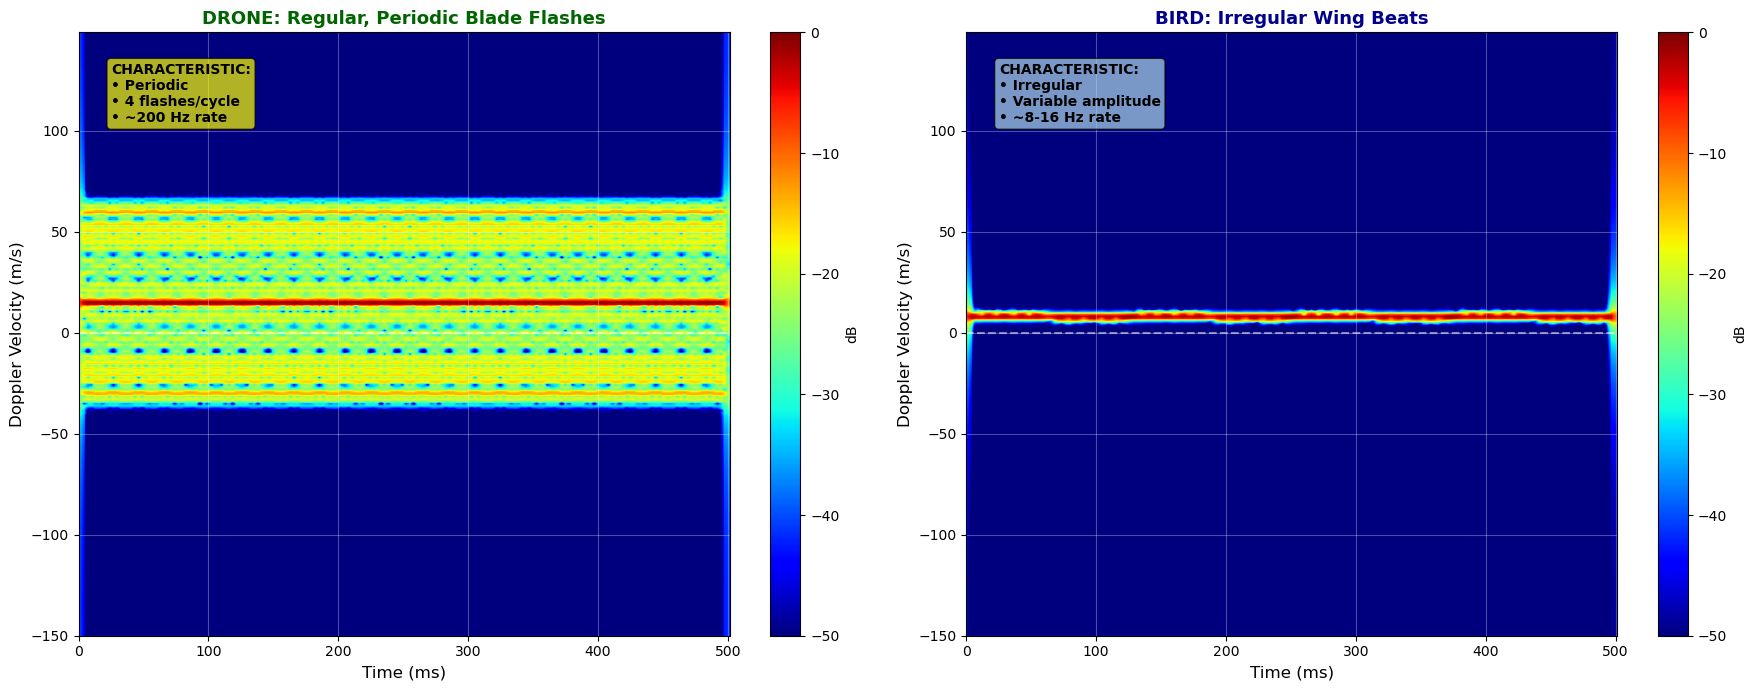


KEY DIFFERENCES:
DRONE:
  ✓ Regular, periodic modulation
  ✓ High frequency (~200 Hz blade flash)
  ✓ Consistent amplitude
  ✓ 4 distinct peaks per rotation

BIRD:
  ✓ Irregular, aperiodic modulation
  ✓ Low frequency (~8 Hz wing beat)
  ✓ Variable amplitude
  ✓ Non-uniform pattern


In [ ]:
def example_drone_vs_bird():
    """
    Compare micro-Doppler signatures of drone vs bird
    """
    # Scenario 1: Drone
    print("\n" + "="*60)
    print("SCENARIO 1: QUADCOPTER DRONE")
    print("="*60)

    radar_drone = MicroDopplerRadar(
        f_c=10e9,
        prf=10e3,
        observation_time=0.5
    )

    radar_drone.add_target_with_rotors(
        range_m=1500,
        velocity_ms=15,
        rcs=0.01,
        num_rotors=4,
        rotor_radius=0.15,
        rpm=3000,
        blade_rcs_fraction=0.15
    )

    radar_drone.add_noise(snr_db=12)
    radar_drone.generate_signal()

    spec_drone, t_drone, v_drone = radar_drone.generate_spectrogram(
        nperseg=256, noverlap=200
    )

    # Scenario 2: Bird
    print("\n" + "="*60)
    print("SCENARIO 2: BIRD")
    print("="*60)

    radar_bird = MicroDopplerRadar(
        f_c=10e9,
        prf=10e3,
        observation_time=0.5
    )

    radar_bird.add_target_with_wings(
        range_m=800,
        velocity_ms=8,
        rcs=0.005,
        wing_beat_freq=8,    # 8 Hz wing beats
        wing_length=0.25,    # 25 cm wings
        irregularity=0.4     # Irregular wing motion
    )

    radar_bird.add_noise(snr_db=12)
    radar_bird.generate_signal()

    spec_bird, t_bird, v_bird = radar_bird.generate_spectrogram(
        nperseg=256, noverlap=200
    )

    # Side-by-side comparison
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))

    # Drone spectrogram
    spec_drone_db = 20 * np.log10(spec_drone + 1e-10)
    spec_drone_db -= np.max(spec_drone_db)

    extent_drone = [t_drone[0]*1000, t_drone[-1]*1000,
                   v_drone[0], v_drone[-1]]

    im1 = axes[0].imshow(spec_drone_db,
                        aspect='auto',
                        extent=extent_drone,
                        cmap='jet',
                        vmin=-50, vmax=0,
                        origin='lower',
                        interpolation='bilinear')

    axes[0].set_xlabel('Time (ms)', fontsize=12)
    axes[0].set_ylabel('Doppler Velocity (m/s)', fontsize=12)
    axes[0].set_title('DRONE: Regular, Periodic Blade Flashes',
                     fontsize=13, fontweight='bold', color='darkgreen')
    axes[0].axhline(0, color='white', linestyle='--', alpha=0.5)
    axes[0].grid(True, alpha=0.3, color='white')
    plt.colorbar(im1, ax=axes[0], label='dB')

    # Add annotation
    axes[0].text(0.05, 0.95, 'CHARACTERISTIC:\n• Periodic\n• 4 flashes/cycle\n• ~200 Hz rate',
                transform=axes[0].transAxes,
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
                verticalalignment='top', fontsize=10, fontweight='bold')

    # Bird spectrogram
    spec_bird_db = 20 * np.log10(spec_bird + 1e-10)
    spec_bird_db -= np.max(spec_bird_db)

    extent_bird = [t_bird[0]*1000, t_bird[-1]*1000,
                  v_bird[0], v_bird[-1]]

    im2 = axes[1].imshow(spec_bird_db,
                        aspect='auto',
                        extent=extent_bird,
                        cmap='jet',
                        vmin=-50, vmax=0,
                        origin='lower',
                        interpolation='bilinear')

    axes[1].set_xlabel('Time (ms)', fontsize=12)
    axes[1].set_ylabel('Doppler Velocity (m/s)', fontsize=12)
    axes[1].set_title('BIRD: Irregular Wing Beats',
                     fontsize=13, fontweight='bold', color='darkblue')
    axes[1].axhline(0, color='white', linestyle='--', alpha=0.5)
    axes[1].grid(True, alpha=0.3, color='white')
    plt.colorbar(im2, ax=axes[1], label='dB')

    # Add annotation
    axes[1].text(0.05, 0.95, 'CHARACTERISTIC:\n• Irregular\n• Variable amplitude\n• ~8-16 Hz rate',
                transform=axes[1].transAxes,
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7),
                verticalalignment='top', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.show()

    print("\n" + "="*60)
    print("KEY DIFFERENCES:")
    print("="*60)
    print("DRONE:")
    print("  ✓ Regular, periodic modulation")
    print("  ✓ High frequency (~200 Hz blade flash)")
    print("  ✓ Consistent amplitude")
    print("  ✓ 4 distinct peaks per rotation")
    print("\nBIRD:")
    print("  ✓ Irregular, aperiodic modulation")
    print("  ✓ Low frequency (~8 Hz wing beat)")
    print("  ✓ Variable amplitude")
    print("  ✓ Non-uniform pattern")
    print("="*60)

# Run comparison
example_drone_vs_bird()

---
# 6. Feature Extraction for Classification

Now that we can see the differences visually, we need to extract features that can be used for classification.

## Key Features

1. **Blade Flash Frequency** - Dominant frequency in the modulation
2. **Modulation Depth** - Peak-to-peak variation
3. **Periodicity Measure** - How regular is the pattern?
4. **Spectral Bandwidth** - Bandwidth of the modulation

These features can feed into:
- Classical ML: Random Forest, SVM
- Deep Learning: CNN on spectrograms (Part 6)

In [ ]:
def extract_micro_doppler_features(radar, spectrogram, time_axis, velocity_axis):
    """
    Extract quantitative features from micro-Doppler spectrogram

    Returns:
    --------
    features : dict
        Dictionary of extracted features
    """
    features = {}

    # 1. Find dominant velocity (body Doppler)
    velocity_profile = np.sum(spectrogram, axis=1)
    dominant_velocity_idx = np.argmax(velocity_profile)
    features['body_velocity'] = velocity_axis[dominant_velocity_idx]

    # 2. Extract velocity centroid over time (micro-Doppler track)
    velocity_centroid = np.zeros(len(time_axis))
    for t_idx in range(len(time_axis)):
        weights = spectrogram[:, t_idx]
        if np.sum(weights) > 0:
            velocity_centroid[t_idx] = np.sum(velocity_axis * weights) / np.sum(weights)

    # 3. Modulation depth (peak-to-peak)
    modulation = velocity_centroid - features['body_velocity']
    features['modulation_depth'] = np.max(modulation) - np.min(modulation)

    # 4. Blade flash frequency (FFT of modulation)
    # Remove mean
    modulation_ac = modulation - np.mean(modulation)

    # FFT to find periodicity
    fft_mod = np.fft.fft(modulation_ac)
    freq_mod = np.fft.fftfreq(len(modulation_ac), d=np.mean(np.diff(time_axis)))

    # Positive frequencies only
    pos_freq_idx = freq_mod > 0
    fft_mod_pos = np.abs(fft_mod[pos_freq_idx])
    freq_mod_pos = freq_mod[pos_freq_idx]

    # Find dominant frequency (blade flash rate)
    # Ignore very low frequencies (< 5 Hz)
    valid_freq_idx = freq_mod_pos > 5
    if np.any(valid_freq_idx):
        peak_idx = np.argmax(fft_mod_pos[valid_freq_idx])
        features['blade_flash_freq'] = freq_mod_pos[valid_freq_idx][peak_idx]
    else:
        features['blade_flash_freq'] = 0

    # 5. Periodicity measure (ratio of peak to mean in FFT)
    if len(fft_mod_pos[valid_freq_idx]) > 0:
        features['periodicity_ratio'] = (np.max(fft_mod_pos[valid_freq_idx]) /
                                        np.mean(fft_mod_pos[valid_freq_idx]))
    else:
        features['periodicity_ratio'] = 1.0

    # 6. Spectral bandwidth (std of velocity distribution)
    features['spectral_bandwidth'] = np.std(velocity_centroid)

    return features

In [ ]:
def demonstrate_feature_extraction():
    """
    Show feature extraction for drone and bird
    """
    print("\n" + "="*60)
    print("FEATURE EXTRACTION DEMONSTRATION")
    print("="*60)

    # Drone features
    radar_drone = MicroDopplerRadar(f_c=10e9, prf=10e3, observation_time=1.0)
    radar_drone.add_target_with_rotors(
        range_m=1500, velocity_ms=15, rcs=0.01,
        num_rotors=4, rotor_radius=0.15, rpm=3000
    )
    radar_drone.add_noise(snr_db=15)
    radar_drone.generate_signal()
    spec_drone, t_drone, v_drone = radar_drone.generate_spectrogram(nperseg=256, noverlap=200)

    features_drone = extract_micro_doppler_features(radar_drone, spec_drone, t_drone, v_drone)

    # Bird features
    radar_bird = MicroDopplerRadar(f_c=10e9, prf=10e3, observation_time=1.0)
    radar_bird.add_target_with_wings(
        range_m=800, velocity_ms=8, rcs=0.005,
        wing_beat_freq=8, wing_length=0.25, irregularity=0.4
    )
    radar_bird.add_noise(snr_db=15)
    radar_bird.generate_signal()
    spec_bird, t_bird, v_bird = radar_bird.generate_spectrogram(nperseg=256, noverlap=200)

    features_bird = extract_micro_doppler_features(radar_bird, spec_bird, t_bird, v_bird)

    # Display comparison
    print("\nDRONE FEATURES:")
    print("-" * 60)
    for key, value in features_drone.items():
        print(f"  {key:25s}: {value:8.2f}")

    print("\nBIRD FEATURES:")
    print("-" * 60)
    for key, value in features_bird.items():
        print(f"  {key:25s}: {value:8.2f}")

    print("\n" + "="*60)
    print("CLASSIFICATION INSIGHTS:")
    print("="*60)
    print("✓ Blade flash freq:  Drone >> Bird  (200 Hz vs ~8 Hz)")
    print("✓ Periodicity ratio: Drone >> Bird  (regular vs irregular)")
    print("✓ Modulation depth:  Similar (both have moving parts)")
    print("\n→ These features can train a classifier (Random Forest, SVM, etc.)")
    print("="*60)

# Run demonstration
demonstrate_feature_extraction()


FEATURE EXTRACTION DEMONSTRATION

MicroDopplerRadar Initialized
Carrier frequency:    10.0 GHz
Wavelength:           3.00 cm
PRF:                  10.0 kHz
Observation time:     1.00 s
Sampling rate:        20.0 kHz
Total samples:        20,000

✓ Rotor target added:
  Range: 1500 m
  Velocity: +15.0 m/s (approaching)
  RCS: 0.010 m²
  Rotors: 4 blades
  Blade radius: 15.0 cm
  RPM: 3,000
  Rotation rate: 50.0 Hz
  Expected blade flash: 200.0 Hz

✓ Noise added: SNR = 15 dB

MicroDopplerRadar Initialized
Carrier frequency:    10.0 GHz
Wavelength:           3.00 cm
PRF:                  10.0 kHz
Observation time:     1.00 s
Sampling rate:        20.0 kHz
Total samples:        20,000

✓ Wing target added (bird):
  Range: 800 m
  Velocity: +8.0 m/s (approaching)
  RCS: 0.005 m²
  Wing beat freq: 8.0 Hz
  Wing length: 25.0 cm
  Irregularity: 40.0%

✓ Noise added: SNR = 15 dB

DRONE FEATURES:
------------------------------------------------------------
  body_velocity            :    15.23


---
# 7. Multiple Targets Scenario

Real-world scenarios have multiple targets. Let's see how they appear together.


COMPLEX SCENARIO: MULTIPLE TARGETS

MicroDopplerRadar Initialized
Carrier frequency:    10.0 GHz
Wavelength:           3.00 cm
PRF:                  10.0 kHz
Observation time:     0.80 s
Sampling rate:        20.0 kHz
Total samples:        16,000

✓ Rotor target added:
  Range: 1500 m
  Velocity: +15.0 m/s (approaching)
  RCS: 0.010 m²
  Rotors: 4 blades
  Blade radius: 15.0 cm
  RPM: 3,000
  Rotation rate: 50.0 Hz
  Expected blade flash: 200.0 Hz

✓ Wing target added (bird):
  Range: 800 m
  Velocity: -5.0 m/s (receding)
  RCS: 0.005 m²
  Wing beat freq: 10.0 Hz
  Wing length: 20.0 cm
  Irregularity: 30.0%

✓ Rotor target added:
  Range: 2000 m
  Velocity: +25.0 m/s (approaching)
  RCS: 0.015 m²
  Rotors: 4 blades
  Blade radius: 12.0 cm
  RPM: 4,000
  Rotation rate: 66.7 Hz
  Expected blade flash: 266.7 Hz

✓ Noise added: SNR = 12 dB


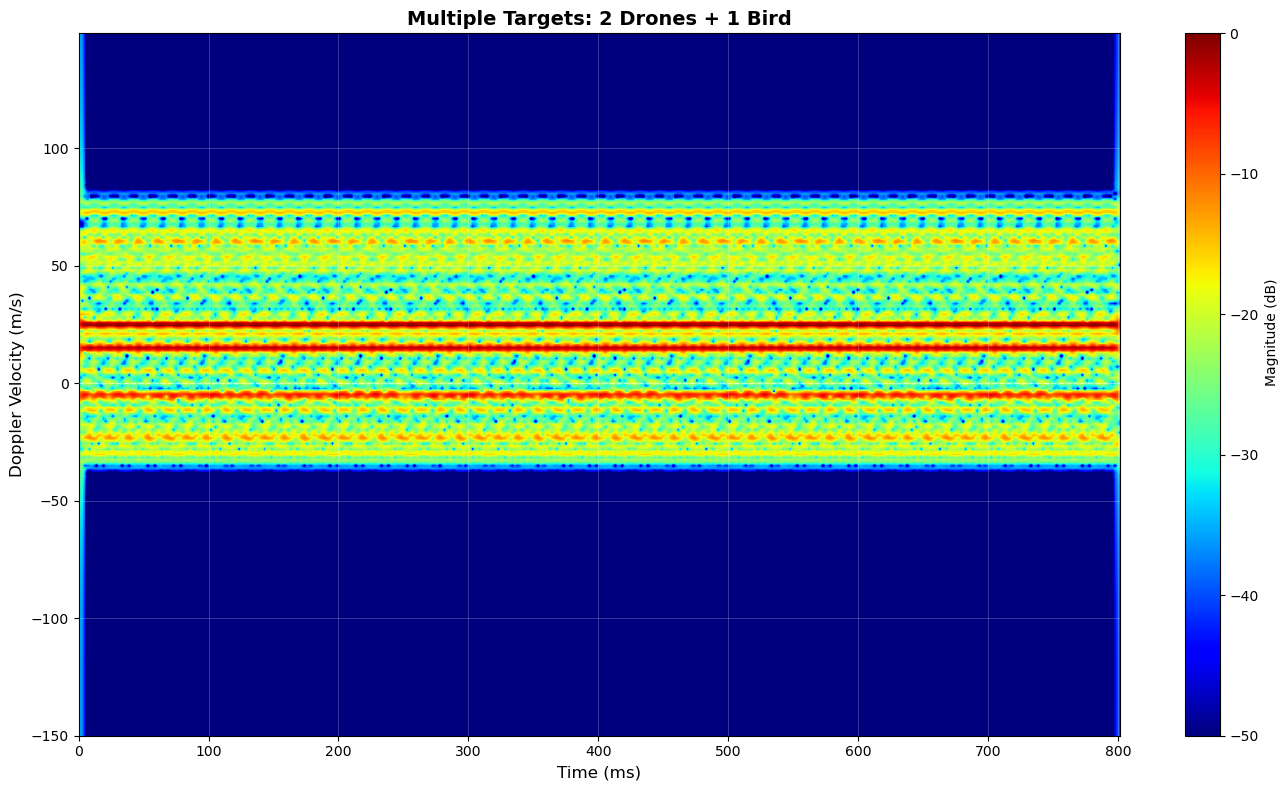


WHAT YOU'RE SEEING:
✓ Three distinct velocity tracks (horizontal streaks)
✓ Two show high-frequency modulation (drones at 200 Hz, 267 Hz)
✓ One shows low-frequency modulation (bird at ~10 Hz)
✓ Each target has unique micro-Doppler signature


In [ ]:
def example_multiple_targets():
    """
    Simulate multiple targets: drone, bird, and aircraft
    """
    print("\n" + "="*60)
    print("COMPLEX SCENARIO: MULTIPLE TARGETS")
    print("="*60)

    radar = MicroDopplerRadar(
        f_c=10e9,
        prf=10e3,
        observation_time=0.8
    )

    # Target 1: Drone
    radar.add_target_with_rotors(
        range_m=1500,
        velocity_ms=15,
        rcs=0.01,
        num_rotors=4,
        rotor_radius=0.15,
        rpm=3000
    )

    # Target 2: Bird
    radar.add_target_with_wings(
        range_m=800,
        velocity_ms=-5,  # Moving away
        rcs=0.005,
        wing_beat_freq=10,
        wing_length=0.20,
        irregularity=0.3
    )

    # Target 3: Another drone (different RPM)
    radar.add_target_with_rotors(
        range_m=2000,
        velocity_ms=25,
        rcs=0.015,
        num_rotors=4,
        rotor_radius=0.12,
        rpm=4000  # Faster rotors
    )

    radar.add_noise(snr_db=12)
    radar.generate_signal()

    spec, t_axis, v_axis = radar.generate_spectrogram(nperseg=256, noverlap=220)

    radar.plot_spectrogram(spec, t_axis, v_axis,
                          title="Multiple Targets: 2 Drones + 1 Bird",
                          db_range=50)

    print("\n" + "="*60)
    print("WHAT YOU'RE SEEING:")
    print("="*60)
    print("✓ Three distinct velocity tracks (horizontal streaks)")
    print("✓ Two show high-frequency modulation (drones at 200 Hz, 267 Hz)")
    print("✓ One shows low-frequency modulation (bird at ~10 Hz)")
    print("✓ Each target has unique micro-Doppler signature")
    print("="*60)

# Run example
example_multiple_targets()

---
# 8. Understanding STFT Parameters

## Trade-offs in Spectrogram Generation

The **Short-Time Fourier Transform (STFT)** is the foundation of spectrograms. Understanding
its parameters is critical for extracting micro-Doppler signatures effectively.

**What STFT does:**
- Divides long signal into short overlapping segments
- Applies FFT to each segment
- Stacks results to create time-frequency image

**Key insight:** You cannot have both perfect time AND frequency resolution simultaneously.
This is fundamental physics (uncertainty principle), not a software limitation!

### 1. Window Length (nperseg)

Number of samples in each FFT window.

**Longer window (e.g., 512 samples):**
- ✅ Better frequency resolution (sharper lines in spectrogram)
- ✅ Can distinguish close frequencies (e.g., 200 Hz vs 205 Hz)
- ❌ Worse time resolution (slow updates)
- ❌ Can't track rapid changes
- **Use when:** Need to precisely identify blade flash rate

**Shorter window (e.g., 128 samples):**
- ✅ Better time resolution (fast updates)
- ✅ Can see rapid changes in modulation
- ❌ Worse frequency resolution (smeared lines)
- ❌ Can't distinguish close frequencies
- **Use when:** Tracking rapid maneuvers or transient events

**Frequency resolution calculation:**
```
Δf = sampling_rate / nperseg

Example: sampling_rate = 20 kHz, nperseg = 256
Δf = 20,000 / 256 = 78.125 Hz
```
This means you can resolve frequencies 78 Hz apart.

**Time resolution calculation:**
```
Δt = nperseg / sampling_rate

Example: nperseg = 256, sampling_rate = 20 kHz
Δt = 256 / 20,000 = 12.8 ms
```
This is how often the spectrogram updates.

**Practical rule of thumb:**
For micro-Doppler with blade flash ~200 Hz:
- Need Δf < 50 Hz → nperseg > sampling_rate / 50
- For 20 kHz sampling: nperseg > 400
- Typical choice: nperseg = 256-512

### 2. Overlap (noverlap)

Number of samples shared between adjacent windows.

**More overlap (e.g., 75% = 3×nperseg/4):**
- ✅ Smoother spectrogram (less choppy)
- ✅ Better for visualization
- ❌ More computation (more FFTs to compute)
- **Use when:** Creating publication-quality plots

**Less overlap (e.g., 50% = nperseg/2):**
- ✅ Faster computation
- ✅ Still adequate for most analysis
- ❌ Slightly choppier appearance
- **Use when:** Real-time processing or quick analysis

**Practical rule of thumb:**
- Start with 50% overlap (noverlap = nperseg // 2)
- Increase to 75% if spectrogram looks choppy
- Never use < 50% (can miss transient events)

### 3. Window Function

Applies a weighting function to each segment before FFT.

**Hann window (default, recommended):**
- Good balance of frequency resolution and leakage suppression
- Smooth transitions at window edges
- **Use when:** General purpose, default choice

**Hamming window:**
- Slightly better frequency resolution than Hann
- Slightly more spectral leakage
- **Use when:** Need to distinguish very close frequencies

**Blackman window:**
- Best spectral leakage suppression
- Wider main lobe (worse resolution)
- **Use when:** Strong interfering signals present

**Rectangular window (no windowing):**
- ❌ Never use! Creates severe spectral leakage
- Makes interpretation impossible

**What is spectral leakage?**
Energy from one frequency "leaks" into adjacent frequency bins, creating
false spectral components. Windowing reduces this artifact.

### 4. Practical Guidelines for Micro-Doppler

**For drone detection (blade flash ~200 Hz):**
```python
nperseg = 256           # Good frequency resolution (78 Hz)
noverlap = 192          # 75% overlap for smooth spectrogram
window = 'hann'         # General purpose
```

**For bird detection (wing beat ~8 Hz):**
```python
nperseg = 512           # Need finer frequency resolution (39 Hz)
noverlap = 384          # 75% overlap
window = 'hann'         # General purpose
```

**For rapid maneuver tracking:**
```python
nperseg = 128           # Fast time updates (6.4 ms)
noverlap = 96           # 75% overlap
window = 'hann'         # General purpose
```

### 5. The Uncertainty Principle

**Mathematical relationship:**
```
Δt × Δf ≥ 1 / (4π)
```

This means:
- If you want Δf = 10 Hz frequency resolution
- You need Δt ≥ 1/(4π×10) ≈ 8 ms time window
- You cannot have 1 ms time resolution AND 10 Hz frequency resolution!

**Practical implication:**
- Choose parameters based on what you need to measure
- For blade flash rate: prioritize frequency resolution
- For maneuver detection: prioritize time resolution
- For balanced view: use medium window size

Let's see the impact visually!


MicroDopplerRadar Initialized
Carrier frequency:    10.0 GHz
Wavelength:           3.00 cm
PRF:                  10.0 kHz
Observation time:     0.50 s
Sampling rate:        20.0 kHz
Total samples:        10,000

✓ Rotor target added:
  Range: 1500 m
  Velocity: +15.0 m/s (approaching)
  RCS: 0.010 m²
  Rotors: 4 blades
  Blade radius: 15.0 cm
  RPM: 3,000
  Rotation rate: 50.0 Hz
  Expected blade flash: 200.0 Hz

✓ Noise added: SNR = 15 dB


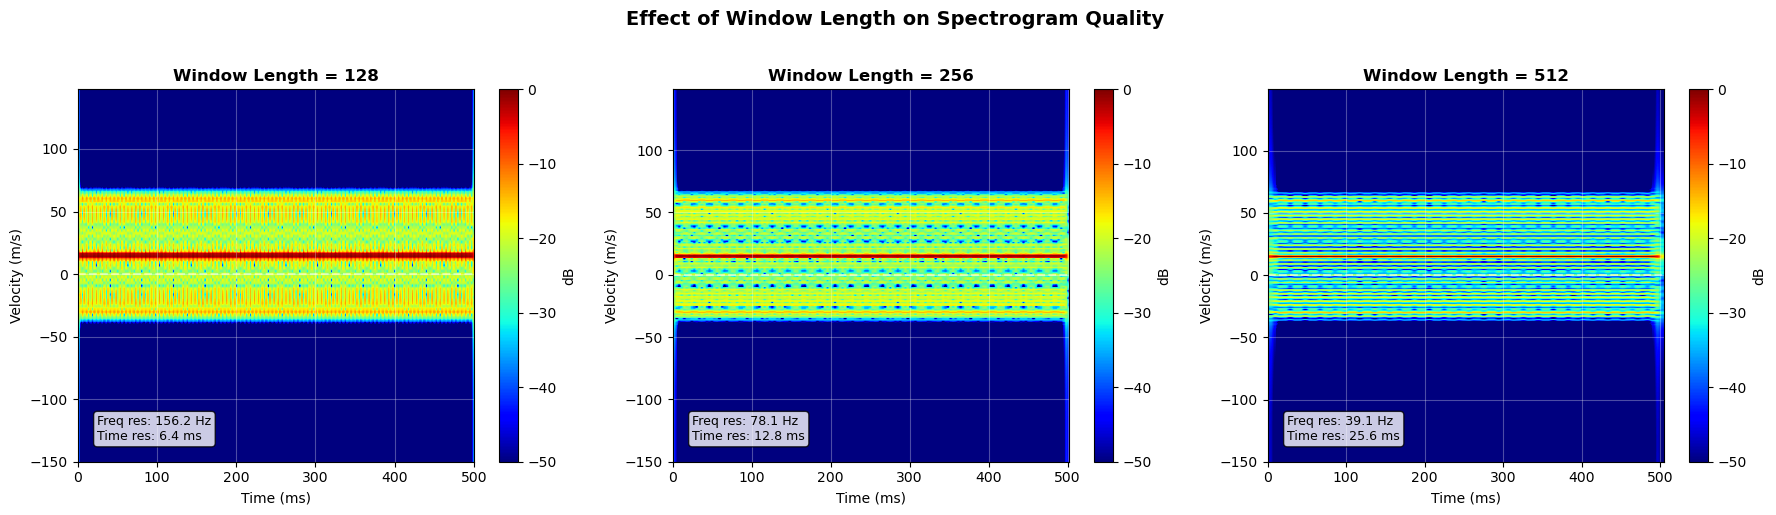


WINDOW LENGTH TRADE-OFFS:
SHORT window (128):
  ✓ Good time resolution (see rapid changes)
  ✗ Poor frequency resolution (smeared in frequency)

MEDIUM window (256):
  ✓ Balanced trade-off
  ✓ Good for most micro-Doppler analysis

LONG window (512):
  ✓ Excellent frequency resolution (sharp lines)
  ✗ Poor time resolution (slow updates)


In [ ]:
def compare_stft_parameters():
    """
    Show how STFT parameters affect spectrogram quality
    """
    # Create drone signal
    radar = MicroDopplerRadar(f_c=10e9, prf=10e3, observation_time=0.5)
    radar.add_target_with_rotors(
        range_m=1500, velocity_ms=15, rcs=0.01,
        num_rotors=4, rotor_radius=0.15, rpm=3000
    )
    radar.add_noise(snr_db=15)
    radar.generate_signal()

    # Different window lengths
    window_sizes = [128, 256, 512]

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for idx, nperseg in enumerate(window_sizes):
        spec, t_axis, v_axis = radar.generate_spectrogram(
            nperseg=nperseg,
            noverlap=int(nperseg * 0.75)
        )

        spec_db = 20 * np.log10(spec + 1e-10)
        spec_db -= np.max(spec_db)

        extent = [t_axis[0]*1000, t_axis[-1]*1000, v_axis[0], v_axis[-1]]

        im = axes[idx].imshow(spec_db,
                             aspect='auto',
                             extent=extent,
                             cmap='jet',
                             vmin=-50, vmax=0,
                             origin='lower')

        axes[idx].set_xlabel('Time (ms)')
        axes[idx].set_ylabel('Velocity (m/s)')
        axes[idx].set_title(f'Window Length = {nperseg}', fontweight='bold')
        axes[idx].axhline(0, color='white', linestyle='--', alpha=0.5)
        axes[idx].grid(True, alpha=0.3, color='white')
        plt.colorbar(im, ax=axes[idx], label='dB')

        # Compute resolutions
        freq_res = radar.sampling_rate / nperseg
        time_res = nperseg / radar.sampling_rate * 1000  # ms

        axes[idx].text(0.05, 0.05,
                      f'Freq res: {freq_res:.1f} Hz\nTime res: {time_res:.1f} ms',
                      transform=axes[idx].transAxes,
                      bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                      verticalalignment='bottom', fontsize=9)

    plt.suptitle('Effect of Window Length on Spectrogram Quality',
                fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

    print("\n" + "="*60)
    print("WINDOW LENGTH TRADE-OFFS:")
    print("="*60)
    print("SHORT window (128):")
    print("  ✓ Good time resolution (see rapid changes)")
    print("  ✗ Poor frequency resolution (smeared in frequency)")
    print("\nMEDIUM window (256):")
    print("  ✓ Balanced trade-off")
    print("  ✓ Good for most micro-Doppler analysis")
    print("\nLONG window (512):")
    print("  ✓ Excellent frequency resolution (sharp lines)")
    print("  ✗ Poor time resolution (slow updates)")
    print("="*60)

# Run comparison
compare_stft_parameters()

---
# 9. Practical Considerations

## Real-World Challenges

### 1. SNR Variation

**The problem:**
- Targets at different ranges have vastly different SNRs
- Range 500m: SNR = 30 dB (strong signal)
- Range 5000m: SNR = 10 dB (weak signal)
- Micro-Doppler signatures degrade with low SNR

**What happens at low SNR:**
```
SNR > 20 dB: Blade flash clearly visible
SNR = 15 dB: Still detectable, slightly noisy
SNR = 10 dB: Hard to distinguish from noise
SNR < 5 dB:  Micro-Doppler lost in noise floor
```

**Solutions:**
- Use adaptive feature extraction (**Adjust thresholds based on SNR**)
- Track integration: **Average features over multiple observations**
- Multi-frame processing: Combine spectrograms from consecutive CPIs
- Machine learning: Train on various SNR levels

### 2. Multi-Target Scenarios

**Challenges:**
- Multiple targets at similar velocities
- Spectrograms overlap in velocity domain
- Which micro-Doppler belongs to which target?

**Example conflict:**
```
Target A: Range 1000m, Velocity +15 m/s (drone)
Target B: Range 2000m, Velocity +16 m/s (drone)
→ RDM shows two separate spots
→ Spectrogram can't distinguish (both ~15 m/s)
```

**Solutions:**
- **Range gating:** Generate **separate spectrograms for each range bin**
- **Cluster analysis:** **Group micro-Doppler features by similarity**
- **Track before detect:** Use **motion history to associate signatures**
- **Array processing:** **Use multi-antenna systems** for spatial separation

**Best practice for this tutorial:**
**Focus on one target at a time (range gate)**, then extend to multiple targets.

### 3. Environmental Effects

**Wind:**
- Drones hover against wind → **velocity fluctuates ±2-5 m/s**
- **Body Doppler becomes time-varying**
- Makes spectrogram "thicker" in velocity dimension
- Solution: **Longer time averaging**, robust feature extraction

**Rain/Snow (Weather clutter):**
- Fills spectrogram with **low-velocity returns**
- **Obscures low-flying drones**
- Micro-Doppler still visible but harder to extract
- Solution: **Clutter filtering** (similar to MTI from Part 2)

**Ground clutter:**
- Strong returns at velocity ≈ 0 m/s
- **Can mask hovering drones**
- Solution: **Notch filter at v=0**, or focus on moving targets only

**Multipath:**
- **Reflections from ground/buildings**
- **Creates ghost targets** with different Doppler
- Can create **false micro-Doppler signatures**
- Solution: E**levation angle filtering, or multiple observation angles**

### 4. Parameter Selection

**Critical decision: Choose STFT window based on target characteristics**

**For small drones (DJI Phantom, etc.):**
```python
rpm = 3000-5000
blade_flash = 200-333 Hz
→ Need Δf < 50 Hz
→ nperseg = 256-512
```

**For large drones (octocopters):**
```python
rpm = 2000-3000
blade_flash = 133-200 Hz  
→ Need Δf < 30 Hz
→ nperseg = 512-1024
```

**For birds:**
```python
wing_beat = 5-15 Hz
→ Need Δf < 5 Hz
→ nperseg = 1024-2048
```

**Rule of thumb:** Window should span several periods of the phenomenon
```
Minimum window ≈ 3-5 periods
For 200 Hz blade flash: window ≥ 3/200 = 15 ms
At 20 kHz sampling: nperseg ≥ 20,000 × 0.015 = 300 samples
```

### 5. Computational Considerations

**Real-time processing:**
- **Each STFT requires nperseg-point FFT**
- 75% overlap → **4× more FFTs than non-overlapping**
- For real-time: **Optimize FFT size (powers of 2)**, use GPU

**Memory requirements:**
```
Spectrogram size = (freq_bins × time_bins) × 8 bytes (complex64)

Example: 
- freq_bins = 256
- time_bins = 200
- Size = 256 × 200 × 8 = 409,600 bytes ≈ 400 KB per target

For 100 targets: 40 MB (manageable)
```

**Processing time:**
```
On typical CPU:
- 256-point FFT: ~5 microseconds
- Full spectrogram (200 windows): ~1 ms
- Feature extraction: ~0.5 ms
→ Total: ~1.5 ms per target (real-time capable!)
```

## Integration with RDM

**Remember from Part 2:**
- RDM shows WHERE targets are (range-velocity)
- Spectrogram shows WHAT targets are (micro-Doppler signature)

**Complete processing pipeline:**

```
Step 1: Generate RDM (Part 2)
   ↓
Step 2: CFAR (Constant False Alarm Rate) Detection (Part 4)
   CFAR is an adaptive thresholding technique that automatically detects targets
   while maintaining a constant false alarm rate in varying noise/clutter
   ↓ (list of detections: range, velocity, magnitude)
Step 3: For each detection, generate micro-Doppler spectrogram
   ↓
Step 4: Extract features from spectrogram
   ↓ (feature vector: blade_flash_freq, periodicity, etc.)
Step 5: Classification (Part 6)
   ↓ (drone / bird / aircraft / clutter)
Step 6: Tracking (Part 7)
   ↓ (track ID, trajectory, threat level)
Output: Classified, tracked targets with confidence scores
```

**Key insight:** RDM and spectrogram are complementary, not alternatives!
- RDM: Spatial information (where is it?)
- Spectrogram: Signature information (what is it?)
- Together: Complete situational awareness

**Practical workflow example:**
1. Process 128-pulse CPI → Generate RDM
2. CFAR detection finds 5 targets
3. For each target:
   - Extract slow-time signal from that range-velocity cell
   - Generate spectrogram
   - Extract micro-Doppler features
   - Classify as drone/bird/other
4. Track targets across multiple CPIs
5. Update classification confidence over time

**Processing resources:**
- RDM: 2D FFT on full data cube (expensive)
- Spectrogram: STFT on single range-velocity cell (cheap)
- **Optimization:** Only compute spectrograms for detected targets!

**Data association challenge:**
```
CPI 1: Detect target at (1000m, 15 m/s) → Classify as drone
CPI 2: Detect target at (1050m, 15 m/s) → Same target?
```
This is the tracking problem (Part 7), but micro-Doppler helps:
- If both show same blade flash rate → Likely same drone
- If signature changes → Might be different target
- Micro-Doppler provides additional discriminant for tracking

---
# 10. Common Issues and Troubleshooting

Before moving to exercises, here are common problems you might encounter and how to fix them:

## Issue 1: "I don't see any micro-Doppler modulation"

**Possible causes:**

**A. SNR too low:**
```python
# Check your SNR
radar.add_noise(snr_db=5)  # TOO LOW!
# Solution: Increase to at least 10 dB
radar.add_noise(snr_db=15)  # BETTER
```

**B. Window too long:**
```python
# If window spans multiple rotation periods, modulation averages out
nperseg = 2048  # TOO LONG for 200 Hz modulation
# Solution: Use shorter window
nperseg = 256   # BETTER
```

**C. Target velocity exactly zero:**
```python
# If body velocity = 0, might be filtered by DC removal
radar.add_target_with_rotors(velocity_ms=0)  # RISKY
# Solution: Use small non-zero velocity
radar.add_target_with_rotors(velocity_ms=5)  # BETTER
```

## Issue 2: "Spectrogram looks noisy/grainy"

**Possible causes:**

**A. Not enough overlap:**
```python
noverlap = nperseg // 4  # 25% overlap - TOO LOW
# Solution: Increase overlap
noverlap = int(nperseg * 0.75)  # 75% - BETTER
```

**B. Observation time too short:**
```python
observation_time = 0.1  # Only 100 ms - TOO SHORT
# Solution: Increase observation time
observation_time = 0.5  # 500 ms - BETTER
```

**C. Need more samples:**
```python
# Increase sampling rate or observation time
radar = MicroDopplerRadar(observation_time=1.0)  # Longer = smoother
```

## Issue 3: "Features don't match expected values"

**Check your calculations:**

```python
# Expected blade flash frequency
num_blades = 4
rpm = 3000
expected_flash = num_blades * (rpm / 60)
print(f"Expected blade flash: {expected_flash} Hz")

# Extract features
features = extract_micro_doppler_features(...)
print(f"Measured blade flash: {features['blade_flash_freq']:.1f} Hz")

# Should be within ±10% due to numerical effects
error = abs(expected_flash - features['blade_flash_freq']) / expected_flash
if error > 0.1:
    print("⚠️ Feature extraction might have issues!")
```

## Issue 4: "Multiple blades not visible in spectrogram"

**This is actually normal!** Here's why:

- Individual blade flashes overlap in time
- What you see: Overall sinusoidal modulation envelope
- The blade flash RATE (200 Hz) is in the periodicity, not individual flashes
- Think of it like: You don't see individual fan blades, but you see the blur pattern

**To verify blade count:**
1. Extract the modulation envelope
2. FFT of the envelope
3. Look for peak at num_blades × rotation_rate

## Issue 5: "Bird and drone look similar"

**Key discriminants to check:**

```python
# Drone characteristics:
# - Regular periodicity (high periodicity_ratio)
# - High blade flash frequency (>100 Hz)
# - Consistent modulation depth

# Bird characteristics:  
# - Irregular periodicity (low periodicity_ratio)
# - Low wing beat frequency (<20 Hz)
# - Variable modulation depth

# If they still look similar, try:
# 1. Longer observation time (1-2 seconds)
# 2. Better SNR (>15 dB)
# 3. Examine periodicity_ratio feature (most discriminative)
```

## Issue 6: "Code runs slowly"

**Optimization tips:**

```python
# 1. Reduce observation time for testing
radar = MicroDopplerRadar(observation_time=0.3)  # Faster

# 2. Use less overlap for quick tests
noverlap = nperseg // 2  # 50% instead of 75%

# 3. Reduce number of samples
sampling_rate = prf  # Minimum (PRF), not 2×PRF

# 4. Don't regenerate signal unnecessarily
signal = radar.generate_signal()  # Once
# Then reuse for multiple spectrograms

# 5. Clear figures after showing
plt.show()
plt.close('all')  # Prevent memory accumulation
```

## Issue 7: "ValueError: noverlap must be less than nperseg"

```python
# Common mistake:
nperseg = 256
noverlap = 256  # ERROR! Can't overlap 100%

# Fix:
noverlap = 255  # Must be < nperseg
# Or better:
noverlap = int(nperseg * 0.75)  # 75% overlap
```

## Debugging Checklist

When things don't work:

```python
# 1. Check radar parameters
print(f"PRF: {radar.prf} Hz")
print(f"Sampling rate: {radar.sampling_rate} Hz")
print(f"Observation time: {radar.observation_time} s")
print(f"Number of samples: {radar.num_samples}")

# 2. Check target parameters
for target in radar.targets:
    if target['type'] == 'rotor':
        flash_freq = target['num_rotors'] * target['rpm'] / 60
        print(f"Expected blade flash: {flash_freq} Hz")

# 3. Check signal power
signal_power = np.mean(np.abs(radar.signal)**2)
print(f"Signal power: {10*np.log10(signal_power):.1f} dB")

# 4. Check spectrogram shape
spec, t, v = radar.generate_spectrogram(nperseg=256)
print(f"Spectrogram shape: {spec.shape}")
print(f"Time range: {t[0]:.3f} to {t[-1]:.3f} s")
print(f"Velocity range: {v[0]:.1f} to {v[-1]:.1f} m/s")

# 5. Verify frequency resolution
freq_res = radar.sampling_rate / nperseg
print(f"Frequency resolution: {freq_res:.1f} Hz")
if freq_res > 50:
    print("⚠️ Frequency resolution might be too coarse!")
```

## Best Practices Summary

1. **Always start with high SNR (15-20 dB)** for learning
2. **Use medium window (256-512)** as default
3. **Use 75% overlap** for smooth spectrograms
4. **Observation time 0.5-1.0 s** for good statistics
5. **Check expected vs measured** blade flash frequency
6. **Plot intermediate results** to verify each step
7. **Start simple** (one target) before adding complexity

---
# 11. Exercises & Experiments

Try these to deepen your understanding:

## Exercise 1: Rotor Count Effect
Create drones with 2, 3, 4, 6 blades:
- How does blade count affect the spectrogram?
- Can you identify the number of blades from the signature?

## Exercise 2: RPM Variation
Vary RPM from 1000 to 5000:
- How does modulation frequency change?
- At what RPM does the signature become hard to see?

## Exercise 3: SNR Threshold
Reduce SNR from 20 dB to 0 dB:
- At what SNR does micro-Doppler disappear?
- Which features are most robust to noise?

## Exercise 4: Window Optimization
For a blade flash rate of 200 Hz:
- What minimum window length do you need to resolve it?
- What happens if window is too short?

## Exercise 5: Feature-Based Classifier
Collect features from 20 drones and 20 birds:
- Train a simple classifier (threshold on blade_flash_freq)
- What accuracy can you achieve?
- Which features are most discriminative?

---
# 12. Key Takeaways

## Conceptual Understanding

✅ **Micro-Doppler** = Time-varying Doppler from rotating/vibrating parts
- Caused by components moving toward/away from radar
- Creates characteristic oscillating pattern in Doppler frequency
- The "fingerprint" that distinguishes target types

✅ **Physics insight:**
- Blade tip velocity: v_radial(t) = r_blade × ω × sin(ωt)
- Micro-Doppler frequency: f_micro(t) = (2/λ) × v_radial(t)
- Peak frequency: f_max = (2 × r_blade × ω) / λ
- Blade flash rate: num_blades × rotation_frequency

✅ **Why RDM can't show it:**
- RDM averages over coherent processing interval (CPI)
- Micro-Doppler oscillates faster than CPI duration
- Averaging hides the time-varying signature

## Technical Skills

✅ **Spectrograms** show time-frequency evolution via STFT
- Divide signal into overlapping windows
- Apply FFT to each window
- Stack results to create 2D image

✅ **STFT parameters** trade off time vs frequency resolution
- Window length (nperseg): Longer = better freq, worse time
- Overlap (noverlap): More = smoother, more computation
- Window function: Hann is good general purpose
- **Cannot have perfect resolution in both domains!** (Uncertainty principle)

✅ **Target signatures are distinctive:**

**Drones:**
- Periodic, sinusoidal modulation
- High blade flash frequency (100-400 Hz)
- Regular pattern (high periodicity ratio)
- Consistent amplitude

**Birds:**
- Irregular, aperiodic modulation
- Low wing beat frequency (5-15 Hz)
- Variable pattern (low periodicity ratio)
- Changing amplitude

## Practical Application

✅ **Feature extraction** enables classification:
- Blade flash frequency (FFT of modulation envelope)
- Modulation depth (peak-to-peak variation)
- Periodicity ratio (regularity measure)
- Spectral bandwidth (spread in frequency)

✅ **Integration with full system:**
1. RDM finds WHERE targets are (range, velocity)
2. CFAR detects targets automatically (Part 4)
3. Spectrogram shows WHAT each target is (micro-Doppler)
4. Features feed classifier (Part 6)
5. Tracking maintains identity over time (Part 7)

✅ **Real-world considerations:**
- SNR affects signature quality (need >10 dB)
- Environmental effects (wind, rain, clutter)
- Computational resources (real-time capable)
- Multi-target separation (range gating)

## Key Equations to Remember

```
Doppler frequency:        f_d = 2v/λ
Micro-Doppler:            f_micro(t) = (2/λ) × r_blade × ω × sin(ωt)
Blade flash rate:         f_flash = N_blades × RPM/60
Frequency resolution:     Δf = f_s / nperseg
Time resolution:          Δt = nperseg / f_s
Uncertainty principle:    Δt × Δf ≥ 1/(4π)
```

## Success Criteria

You should now be able to:
- ✅ Explain physically why rotating blades create frequency modulation
- ✅ Generate spectrograms from radar time-series data
- ✅ Identify blade flash signatures visually in spectrograms
- ✅ Extract blade flash frequency programmatically from features
- ✅ Distinguish drone spectrograms from bird spectrograms
- ✅ Understand STFT parameter trade-offs
- ✅ Choose appropriate window parameters for different targets
- ✅ Troubleshoot common issues in micro-Doppler analysis

## What You've Built

A complete micro-Doppler analysis toolkit:
- `MicroDopplerRadar` class (self-contained simulator)
- Signal generation with rotor/wing physics
- Spectrogram generation with configurable STFT
- Feature extraction algorithms
- Visualization tools
- Analysis and comparison capabilities

---
# What's Next?

You now understand micro-Doppler signatures! In **Part 4**, we'll cover:

1. **CFAR Detection** - Automatically detect targets in RDM/spectrograms
2. **Classical CFAR** - CA-CFAR, OS-CFAR algorithms  
3. **Neural CFAR** - Learned detection using CNNs
4. **Performance Analysis** - Probability of detection vs false alarm curves
5. **Threshold Optimization** - Balancing sensitivity and false alarms

**The connection:**
- Part 2 (RDM): Shows WHERE targets are
- Part 3 (Micro-Doppler): Shows WHAT targets are
- **Part 4 (CFAR): Automatically DETECTS targets in noise/clutter**
- Part 5 (Clutter): Removes unwanted returns
- Part 6 (Classification): Identifies target types using micro-Doppler features

**Next Steps:**
1. ✅ Run all examples in this notebook
2. ✅ Complete the exercises below
3. ✅ Experiment with different parameters
4. ✅ Build intuition: "What makes this target unique?"
5. ✅ Think about classification: "How would I train a detector?"

---

In [ ]:
# Notebook size check
import os
import sys

notebook_file = 'part3_micro_doppler.ipynb'
if os.path.exists(notebook_file):
    size_bytes = os.path.getsize(notebook_file)
    size_kb = size_bytes / 1024

    print("\n" + "="*60)
    print(f"Notebook size: {size_kb:.1f} KB ({size_bytes:,} bytes)")
    if size_kb > 900 and size_kb < 1024:
        print("⚠️  WARNING: 1 MB limit!")
    elif size_kb >= 1024:
        print("⚠️ Exceeded 1 MB Limit !!")
    else:
        print("✓ Size is good!")
    print("="*60)
else:
    print(f"File {notebook_file} not found")

print("\n" + "="*60)
print("PART 3: MICRO-DOPPLER SIGNATURES - COMPLETE!")
print("="*60)
print("\nCongratulations! You've completed Part 3.")
print("\nYou now understand:")
print("  ✓ What micro-Doppler is and why it matters")
print("  ✓ Physics of rotor blade modulation")
print("  ✓ How to generate and analyze spectrograms")
print("  ✓ Feature extraction for classification")
print("  ✓ Drone vs bird signature differences")
print("\nReady for Part 4: CFAR Detection!")
print("="*60)


Notebook size: 1843.9 KB (1,888,128 bytes)
⚠️ Exceeded 1 MB Limit !!

PART 3: MICRO-DOPPLER SIGNATURES - COMPLETE!

Congratulations! You've completed Part 3.

You now understand:
  ✓ What micro-Doppler is and why it matters
  ✓ Physics of rotor blade modulation
  ✓ How to generate and analyze spectrograms
  ✓ Feature extraction for classification
  ✓ Drone vs bird signature differences

Ready for Part 4: CFAR Detection!
